# API tải dataset từ kaggle vào colab


In [1]:
!curl -L -o spaceship-titanic.zip \
  "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/34377/3220602/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1757580320&Signature=GYLLqYbgEmL6UXO9IjxsRr1Za7%2FVUodUckglbQufThrb4Lr8qrcmI84wuvtxmiERWUGnBY%2FlIWUCJB%2BpG0xdbhAFFTF%2B%2B%2BG6KOAa7%2FedSZcZtqCAqgRq30Ib%2BjUYPIMpYHBLbWxptBb9IjhMtf1RVYiaBnbpvhdOA7a%2FhyIG3fhhZPWPWdal%2BsUayyhrjPT7mDFVwGUdD7R7Kx8fYitx4EbqORfCe8qgLSOYbjSL8MKcIYy8DJqyJY9h5dO3ZoeqKdp0c6ZF8PNyLTe7qAZ95HwYndFpqeU2nz%2Fa4o2vODoqvyZior4RKhb%2B24UrxiRFWVxnrESfVCVLJvVpC9wfJA%3D%3D&response-content-disposition=attachment%3B+filename%3Dspaceship-titanic.zip"
!unzip spaceship-titanic.zip -d spaceship_titanic

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  299k  100  299k    0     0   293k      0  0:00:01  0:00:01 --:--:--  294k
Archive:  spaceship-titanic.zip
  inflating: spaceship_titanic/sample_submission.csv  
  inflating: spaceship_titanic/test.csv  
  inflating: spaceship_titanic/train.csv  


# Deep learning for spaceshop_titanic dataset
## SETUP AND INSTALLATIONS

In [2]:
!pip install pytorch-tabnet scikit-learn pandas numpy matplotlib seaborn torch torchvision

## IMPORTS & GLOBAL CONFIGURATION

In [3]:
import os
import random
import logging
import sys
from abc import ABC, abstractmethod
from typing import Dict, List, Tuple, Any, Optional
from dataclasses import dataclass, field
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
warnings.filterwarnings('ignore')

## GLOBAL CONFIGURATION

In [4]:
@dataclass
class GlobalConfig:
    """Global configuration for the entire pipeline"""
    random_seed: int = 42
    test_size: float = 0.2
    device: str = "auto"  # auto, cuda, cpu
    verbose: bool = True
    plot_style: str = "whitegrid"
    figure_size: Tuple[int, int] = (12, 8)
    save_models: bool = True
    model_save_path: str = "./models"

# Fix logging configuration for Jupyter Notebook
def setup_notebook_logging(verbose: bool = True):
    """Setup logging specifically for Jupyter Notebook"""
    # Clear any existing handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    # Create a custom formatter
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

    # Create stream handler that outputs to stdout
    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(formatter)

    # Set up root logger
    logging.basicConfig(
        level=logging.INFO if verbose else logging.WARNING,
        handlers=[handler],
        format='%(asctime)s - %(levelname)s - %(message)s',
        force=True  # Force reconfiguration
    )

    # Create and return logger
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO if verbose else logging.WARNING)

    return logger

def setup_global_config(config: GlobalConfig):
    """Setup global configuration and environment"""
    # Set random seeds
    random.seed(config.random_seed)
    np.random.seed(config.random_seed)
    torch.manual_seed(config.random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config.random_seed)
        torch.cuda.manual_seed_all(config.random_seed)

    # Configure device
    if config.device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(config.device)

    # Setup plotting
    plt.style.use('default')
    sns.set_style(config.plot_style)
    plt.rcParams['figure.figsize'] = config.figure_size

    # Create directories
    os.makedirs(config.model_save_path, exist_ok=True)

    # Setup logging
    # logging.basicConfig(
    #     level=logging.INFO if config.verbose else logging.WARNING,
    #     format='%(asctime)s - %(levelname)s - %(message)s'
    # )
    # Setup logging for notebook
    logger = setup_notebook_logging(config.verbose)

    # logger = logging.getLogger(__name__)
    # logger.info(f"Global setup completed!")
    # logger.info(f"Device: {device}")
    # logger.info(f"Random seed: {config.random_seed}")

    # Test logging immediately
    print(f"Configuration completed!")
    print(f"Device: {device}")
    print(f"PyTorch version: {torch.__version__}")

    logger.info(f"Global setup completed!")
    logger.info(f"Device: {device}")
    logger.info(f"Random seed: {config.random_seed}")

    return device, logger

# Initialize global configuration
global_config = GlobalConfig()
DEVICE, LOGGER = setup_global_config(global_config)

# print(f"Configuration completed!")
# print(f"Device: {DEVICE}")
# print(f"PyTorch version: {torch.__version__}")
# Test the logger
LOGGER.info("Logger is working correctly!")
print("If you see this message above, logging is fixed!")

Configuration completed!
Device: cuda
PyTorch version: 2.8.0+cu126
2025-09-08 16:01:55,916 - INFO - Global setup completed!
2025-09-08 16:01:55,917 - INFO - Device: cuda
2025-09-08 16:01:55,918 - INFO - Random seed: 42
2025-09-08 16:01:55,919 - INFO - Logger is working correctly!
If you see this message above, logging is fixed!


## UTILITIES & BASE CLASSES

In [5]:
@dataclass
class MLPConfig:
    """Configuration for MLP model"""
    hidden_dims: List[int] = field(default_factory=lambda: [128, 64])
    dropout_rate: float = 0.3
    learning_rate: float = 1e-3
    batch_size: int = 64
    epochs: int = 50
    patience: int = 5
    weight_decay: float = 0.0

@dataclass
class TabNetConfig:
    """Configuration for TabNet model"""
    n_d: int = 16
    n_a: int = 16
    n_steps: int = 5
    gamma: float = 1.5
    n_independent: int = 2
    n_shared: int = 2
    lambda_sparse: float = 1e-3
    learning_rate: float = 2e-2
    weight_decay: float = 1e-5
    batch_size: int = 256
    epochs: int = 200
    patience: int = 15
    step_size: int = 20
    scheduler_gamma: float = 0.95

@dataclass
class NODEConfig:
    """Configuration for NODE model"""
    num_trees: int = 128
    depth: int = 6
    tree_dim: int = 3
    dropout_rate: float = 0.1
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    batch_size: int = 128
    epochs: int = 100
    patience: int = 10

## BASE MODEL CLASS

In [6]:
class BaseModel(ABC):
    """Abstract base class for all models"""

    def __init__(self, config: Any, model_name: str):
        self.config = config
        self.model_name = model_name
        self.model = None
        self.is_trained = False
        self.training_history = {}
        self.device = DEVICE

    @abstractmethod
    def build_model(self, input_size: int) -> None:
        """Build the model architecture"""
        pass

    @abstractmethod
    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, List[float]]:
        """Train the model"""
        pass

    @abstractmethod
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        pass

    @abstractmethod
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Make probability predictions"""
        pass

    def save_model(self, path: str) -> None:
        """Save the trained model"""
        if not self.is_trained:
            LOGGER.warning(f"Model {self.model_name} is not trained yet!")
            return

        save_path = Path(path) / f"{self.model_name.lower()}_model.pkl"
        torch.save({
            'model_state_dict': self.model.state_dict() if hasattr(self.model, 'state_dict') else self.model,
            'config': self.config,
            'training_history': self.training_history
        }, save_path)
        LOGGER.info(f"Model saved: {save_path}")

    def load_model(self, path: str) -> None:
        """Load a trained model"""
        load_path = Path(path) / f"{self.model_name.lower()}_model.pkl"
        checkpoint = torch.load(load_path, map_location=self.device)

        if hasattr(self.model, 'load_state_dict'):
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model = checkpoint['model_state_dict']

        self.training_history = checkpoint.get('training_history', {})
        self.is_trained = True
        LOGGER.info(f"Model loaded: {load_path}")

### TRAINING UTILITIES

In [7]:
class EarlyStopping:
    """Early stopping utility"""

    def __init__(self, patience: int = 7, min_delta: float = 0, restore_best_weights: bool = True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss: float, model) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy() if hasattr(model, 'state_dict') else model
        else:
            self.counter += 1

        return self.counter >= self.patience

    def restore_best_weights_to_model(self, model):
        if self.best_weights is not None and hasattr(model, 'load_state_dict'):
            model.load_state_dict(self.best_weights)

def prepare_torch_data(X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool = True) -> DataLoader:
    """Prepare PyTorch DataLoader"""
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y.reshape(-1, 1))
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

## EVALUATION UTILITIES

In [8]:
class ModelEvaluator:
    """Unified model evaluation utilities"""

    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
        """Calculate comprehensive metrics"""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'f1_macro': f1_score(y_true, y_pred, average='macro'),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_true, y_prob)
        }

    @staticmethod
    def evaluate_model(model: BaseModel, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
        """Evaluate a model and return metrics"""
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)
        return ModelEvaluator.calculate_metrics(y, y_pred, y_prob)

    @staticmethod
    def compare_models(models: Dict[str, BaseModel], X_val: np.ndarray, y_val: np.ndarray) -> pd.DataFrame:
        """Compare multiple models"""
        results = {}
        for name, model in models.items():
            if model.is_trained:
                metrics = ModelEvaluator.evaluate_model(model, X_val, y_val)
                results[name] = metrics
            else:
                LOGGER.warning(f"Model {name} is not trained!")

        return pd.DataFrame(results).T

## VISUALIZATION UTILITIES

In [9]:
class ModelVisualizer:
    """Model visualization utilities"""

    @staticmethod
    def plot_training_curves(models: Dict[str, BaseModel], figsize: Tuple[int, int] = (15, 5)):
        """Plot training curves for models"""
        trained_models = {name: model for name, model in models.items()
                         if model.is_trained and model.training_history}

        if not trained_models:
            LOGGER.warning("No trained models with training history found!")
            return

        n_models = len(trained_models)
        fig, axes = plt.subplots(1, n_models, figsize=(figsize[0], figsize[1]))
        if n_models == 1:
            axes = [axes]

        for idx, (name, model) in enumerate(trained_models.items()):
            history = model.training_history
            if 'train_loss' in history and 'val_loss' in history:
                axes[idx].plot(history['train_loss'], label='Training Loss', color='blue', alpha=0.7)
                axes[idx].plot(history['val_loss'], label='Validation Loss', color='red', alpha=0.7)
                axes[idx].set_title(f'{name} Training Curves')
                axes[idx].set_xlabel('Epoch')
                axes[idx].set_ylabel('Loss')
                axes[idx].legend()
                axes[idx].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_model_comparison(results_df: pd.DataFrame, figsize: Tuple[int, int] = (12, 6)):
        """Plot model comparison"""
        if results_df.empty:
            LOGGER.warning("No results to plot!")
            return

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Bar plot for all metrics
        results_df.plot(kind='bar', ax=axes[0], alpha=0.8)
        axes[0].set_title('Model Performance Comparison')
        axes[0].set_ylabel('Score')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0].grid(True, alpha=0.3)

        # Horizontal bar plot for ROC-AUC
        if 'roc_auc' in results_df.columns:
            results_df['roc_auc'].plot(kind='barh', ax=axes[1], color='skyblue', alpha=0.8)
            axes[1].set_title('ROC-AUC Comparison')
            axes[1].set_xlabel('ROC-AUC Score')
            axes[1].grid(True, alpha=0.3)

            # Add value labels
            for i, v in enumerate(results_df['roc_auc'].values):
                axes[1].text(v + 0.005, i, f'{v:.4f}', va='center')

        plt.tight_layout()
        plt.show()

print("Utilities & Base Classes loaded successfully!")

Utilities & Base Classes loaded successfully!


## DATA PREPROCESSING PIPELINE

In [10]:
class DataPreprocessor:
    """Modular data preprocessing pipeline"""

    def __init__(self, test_size: float = 0.2, random_state: int = 42):
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.feature_names = None

    def load_data(self, train_path: str, test_path: str, sample_submission_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Load datasets"""
        try:
            train_df = pd.read_csv(train_path)
            test_df = pd.read_csv(test_path)
            sample_submission = pd.read_csv(sample_submission_path)

            LOGGER.info(f"Data loaded - Train: {train_df.shape}, Test: {test_df.shape}")
            return train_df, test_df, sample_submission

        except FileNotFoundError as e:
            LOGGER.error(f"File not found: {e}")
            raise

    def feature_engineering(self, df: pd.DataFrame, is_train: bool = True) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """Feature engineering pipeline"""
        df = df.copy()

        # Extract features from PassengerId
        df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
        df['Group_Size'] = df.groupby('Group')['Group'].transform('count')

        # Extract deck, num, side from Cabin
        cabin_split = df['Cabin'].str.split('/', expand=True)
        df['Deck'] = cabin_split[0]
        df['Num'] = cabin_split[1].astype(float)
        df['Side'] = cabin_split[2]

        # Create spending features
        spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        df['Total_Spending'] = df[spending_cols].sum(axis=1)
        df['Has_Spending'] = (df['Total_Spending'] > 0).astype(int)
        df['Spending_per_Service'] = df['Total_Spending'] / (df[spending_cols] > 0).sum(axis=1).replace(0, 1)

        # Age categories
        df['Age_Group'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                               labels=['Child', 'Teen', 'Young_Adult', 'Adult', 'Senior'])

        # Handle target variable
        target = None
        drop_cols = ['PassengerId', 'Name', 'Cabin']

        if is_train and 'Transported' in df.columns:
            target = df['Transported']
            drop_cols.append('Transported')

        # Drop unnecessary columns
        df = df.drop(columns=drop_cols)

        return df, target

    def handle_missing_values(self, X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame):
        """Handle missing values with appropriate strategies"""
        # Identify column types
        categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Impute categorical variables
        for col in categorical_cols:
            if col in X_train.columns:
                mode_imputer = SimpleImputer(strategy='most_frequent')
                X_train[col] = mode_imputer.fit_transform(X_train[[col]]).ravel()
                X_val[col] = mode_imputer.transform(X_val[[col]]).ravel()
                X_test[col] = mode_imputer.transform(X_test[[col]]).ravel()

        # Impute numerical variables
        for col in numerical_cols:
            if col in X_train.columns:
                median_imputer = SimpleImputer(strategy='median')
                X_train[col] = median_imputer.fit_transform(X_train[[col]]).ravel()
                X_val[col] = median_imputer.transform(X_val[[col]]).ravel()
                X_test[col] = median_imputer.transform(X_test[[col]]).ravel()

        LOGGER.info("Missing values handled")
        return X_train, X_val, X_test

    def encode_categorical_features(self, X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame):
        """Encode categorical features"""
        categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

        for col in categorical_cols:
            if col in X_train.columns:
                # Fit on combined data for consistency
                combined_data = pd.concat([X_train[col], X_val[col], X_test[col]], axis=0)
                le = LabelEncoder()
                le.fit(combined_data.astype(str))

                X_train[col] = le.transform(X_train[col].astype(str))
                X_val[col] = le.transform(X_val[col].astype(str))
                X_test[col] = le.transform(X_test[col].astype(str))
                self.label_encoders[col] = le

        LOGGER.info("Categorical features encoded")
        return X_train, X_val, X_test

    def scale_features(self, X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame):
        """Scale numerical features"""
        self.feature_names = X_train.columns.tolist()

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # Convert back to DataFrame
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=self.feature_names)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=self.feature_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=self.feature_names)

        LOGGER.info("Features scaled")
        return X_train_scaled, X_val_scaled, X_test_scaled

    def prepare_data(self, train_path: str, test_path: str, sample_submission_path: str) -> Dict[str, Any]:
        """Complete data preparation pipeline"""
        LOGGER.info("Starting data preparation...")

        # Load data
        train_df, test_df, sample_submission = self.load_data(train_path, test_path, sample_submission_path)

        # Feature engineering
        X_full, y = self.feature_engineering(train_df, is_train=True)
        X_test, _ = self.feature_engineering(test_df, is_train=False)

        # Train-validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X_full, y.astype(int).values,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y.astype(int).values
        )

        # Handle missing values
        X_train, X_val, X_test = self.handle_missing_values(X_train, X_val, X_test)

        # Encode categorical features
        X_train, X_val, X_test = self.encode_categorical_features(X_train, X_val, X_test)

        # Scale features
        X_train_scaled, X_val_scaled, X_test_scaled = self.scale_features(X_train, X_val, X_test)

        LOGGER.info(f"Data preparation completed!")
        LOGGER.info(f"   Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")
        LOGGER.info(f"   Features: {len(self.feature_names)}")

        return {
            'X_train': X_train_scaled.values,
            'X_val': X_val_scaled.values,
            'X_test': X_test_scaled.values,
            'y_train': y_train,
            'y_val': y_val,
            'feature_names': self.feature_names,
            'test_ids': test_df['PassengerId'].values,
            'sample_submission': sample_submission
        }

# Initialize preprocessor
preprocessor = DataPreprocessor(test_size=global_config.test_size, random_state=global_config.random_seed)
print("Data preprocessing pipeline ready!")

Data preprocessing pipeline ready!


## MODEL IMPLEMENTATIONS

### MLP MODEL

In [11]:
class MLPModel(BaseModel):
    """Multilayer Perceptron Model"""

    def __init__(self, config: MLPConfig):
        super().__init__(config, "MLP")

    def build_model(self, input_size: int) -> None:
        """Build MLP architecture"""
        layers = []
        prev_dim = input_size

        # Hidden layers
        for hidden_dim in self.config.hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(self.config.dropout_rate)
            ])
            prev_dim = hidden_dim

        # Output layer
        layers.extend([
            nn.Linear(prev_dim, 1),
            nn.Sigmoid()
        ])

        self.model = nn.Sequential(*layers).to(self.device)
        LOGGER.info(f"{self.model_name} model built with {sum(p.numel() for p in self.model.parameters()):,} parameters")

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, List[float]]:
        """Train the MLP model"""
        if self.model is None:
            self.build_model(X_train.shape[1])

        # Setup training components
        train_loader = prepare_torch_data(X_train, y_train, self.config.batch_size, shuffle=True)
        val_loader = prepare_torch_data(X_val, y_val, self.config.batch_size, shuffle=False)

        optimizer = optim.Adam(self.model.parameters(),
                             lr=self.config.learning_rate,
                             weight_decay=self.config.weight_decay)
        criterion = nn.BCELoss()
        early_stopping = EarlyStopping(patience=self.config.patience, restore_best_weights=True)

        # Training loop
        train_losses, val_losses = [], []

        LOGGER.info(f"Training {self.model_name} for {self.config.epochs} epochs...")

        for epoch in range(self.config.epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0

            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation phase
            self.model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Early stopping check
            if early_stopping(val_loss, self.model):
                LOGGER.info(f"Early stopping at epoch {epoch + 1}")
                break

            if epoch % 10 == 0:
                LOGGER.info(f"Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Restore best weights
        early_stopping.restore_best_weights_to_model(self.model)

        self.training_history = {'train_loss': train_losses, 'val_loss': val_losses}
        self.is_trained = True

        LOGGER.info(f"{self.model_name} training completed!")
        return self.training_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            predictions = (outputs > 0.5).cpu().numpy().flatten().astype(int)
        return predictions

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Make probability predictions"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            probabilities = outputs.cpu().numpy().flatten()
        return probabilities

print("MLP model classes loaded successfully!")

MLP model classes loaded successfully!


### TABNET MODEL

In [12]:
class TabNetModel(BaseModel):
    """TabNet Model Wrapper"""

    def __init__(self, config: TabNetConfig):
        super().__init__(config, "TabNet")

    def build_model(self, input_size: int) -> None:
        """Build TabNet model"""
        self.model = TabNetClassifier(
            n_d=self.config.n_d,
            n_a=self.config.n_a,
            n_steps=self.config.n_steps,
            gamma=self.config.gamma,
            n_independent=self.config.n_independent,
            n_shared=self.config.n_shared,
            lambda_sparse=self.config.lambda_sparse,
            optimizer_fn=optim.Adam,
            optimizer_params={'lr': self.config.learning_rate, 'weight_decay': self.config.weight_decay},
            scheduler_fn=optim.lr_scheduler.StepLR,
            scheduler_params={'step_size': self.config.step_size, 'gamma': self.config.scheduler_gamma},
            device_name='auto',
            verbose=0
        )
        LOGGER.info(f"{self.model_name} model built")

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, List[float]]:
        """Train TabNet model"""
        if self.model is None:
            self.build_model(X_train.shape[1])

        LOGGER.info(f"Training {self.model_name} for {self.config.epochs} epochs...")

        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            batch_size=self.config.batch_size,
            max_epochs=self.config.epochs,
            patience=self.config.patience,
            eval_name=['validation'],
            eval_metric=['auc', 'logloss']
        )

        train_loss_history = self.model.history['loss']
        val_loss_history = self.model.history['validation_logloss']

        self.training_history = {
            'train_loss': train_loss_history,
            'val_loss': val_loss_history,
            'feature_importances': self.model.feature_importances_
        }
        self.is_trained = True

        LOGGER.info(f"{self.model_name} training completed!")
        return self.training_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        probabilities = self.model.predict_proba(X)[:, 1]
        return (probabilities > 0.5).astype(int)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Make probability predictions"""
        return self.model.predict_proba(X)[:, 1]

print("TABNET model classes loaded successfully!")

TABNET model classes loaded successfully!


### NODE MODEL

In [13]:
class NODEModel(BaseModel):
    """Neural Oblivious Decision Ensembles Model"""

    def __init__(self, config: NODEConfig):
        super().__init__(config, "NODE")

    def _build_node_architecture(self, input_size: int):
        """Build NODE architecture"""
        class NODE(nn.Module):
            def __init__(self, input_size, num_trees, depth, tree_dim, dropout_rate):
                super(NODE, self).__init__()
                self.num_trees = num_trees
                self.depth = depth
                self.tree_dim = tree_dim

                # Feature selection layer
                self.feature_selection = nn.Linear(input_size, num_trees * depth)

                # Tree layers
                self.trees = nn.ModuleList([
                    nn.Sequential(
                        nn.Linear(depth, tree_dim * (2 ** depth)),
                        nn.ReLU(),
                        nn.Dropout(dropout_rate),
                        nn.Linear(tree_dim * (2 ** depth), 2 ** depth)
                    ) for _ in range(num_trees)
                ])

                # Output layer
                self.output = nn.Sequential(
                    nn.Linear(num_trees, 64),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(64, 1),
                    nn.Sigmoid()
                )

            def forward(self, x):
                batch_size = x.size(0)

                # Feature selection
                features = self.feature_selection(x)
                features = features.view(batch_size, self.num_trees, self.depth)

                # Process through trees
                tree_outputs = []
                for i, tree in enumerate(self.trees):
                    tree_input = features[:, i, :]
                    tree_out = tree(tree_input)
                    tree_out = tree_out.mean(dim=1, keepdim=True)
                    tree_outputs.append(tree_out)

                # Concatenate tree outputs
                ensemble_out = torch.cat(tree_outputs, dim=1)

                # Final prediction
                output = self.output(ensemble_out)
                return output

        return NODE(input_size, self.config.num_trees, self.config.depth,
                   self.config.tree_dim, self.config.dropout_rate)

    def build_model(self, input_size: int) -> None:
        """Build NODE model"""
        self.model = self._build_node_architecture(input_size).to(self.device)
        LOGGER.info(f"{self.model_name} model built with {sum(p.numel() for p in self.model.parameters()):,} parameters")

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, List[float]]:
        """Train NODE model"""
        if self.model is None:
            self.build_model(X_train.shape[1])

        # Setup training components
        train_loader = prepare_torch_data(X_train, y_train, self.config.batch_size, shuffle=True)
        val_loader = prepare_torch_data(X_val, y_val, self.config.batch_size, shuffle=False)

        optimizer = optim.AdamW(self.model.parameters(),
                              lr=self.config.learning_rate,
                              weight_decay=self.config.weight_decay)
        criterion = nn.BCELoss()
        early_stopping = EarlyStopping(patience=self.config.patience, restore_best_weights=True)

        # Training loop
        train_losses, val_losses = [], []

        LOGGER.info(f"Training {self.model_name} for {self.config.epochs} epochs...")

        for epoch in range(self.config.epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0

            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation phase
            self.model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Early stopping check
            if early_stopping(val_loss, self.model):
                LOGGER.info(f"Early stopping at epoch {epoch + 1}")
                break

            if epoch % 20 == 0:
                LOGGER.info(f"Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Restore best weights
        early_stopping.restore_best_weights_to_model(self.model)

        self.training_history = {'train_loss': train_losses, 'val_loss': val_losses}
        self.is_trained = True

        LOGGER.info(f"{self.model_name} training completed!")
        return self.training_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            predictions = (outputs > 0.5).cpu().numpy().flatten().astype(int)
        return predictions

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Make probability predictions"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            probabilities = outputs.cpu().numpy().flatten()
        return probabilities

print("Node model classes loaded successfully!")

Node model classes loaded successfully!


## TRAINING & EVALUATION PIPELINE

In [14]:
class ModelTrainingPipeline:
    """Complete training and evaluation pipeline"""

    def __init__(self, data_config: Dict[str, Any]):
        self.data = data_config
        self.models = {}
        self.results = {}

    def initialize_models(self, model_configs: Dict[str, Any]) -> None:
        """Initialize all models"""
        LOGGER.info("Initializing models...")

        if 'mlp' in model_configs:
            self.models['MLP'] = MLPModel(model_configs['mlp'])

        if 'tabnet' in model_configs:
            self.models['TabNet'] = TabNetModel(model_configs['tabnet'])

        if 'node' in model_configs:
            self.models['NODE'] = NODEModel(model_configs['node'])

        LOGGER.info(f"Initialized {len(self.models)} models: {list(self.models.keys())}")

    def train_model(self, model_name: str) -> None:
        """Train a specific model"""
        if model_name not in self.models:
            LOGGER.error(f"Model {model_name} not found!")
            return

        model = self.models[model_name]
        LOGGER.info(f"Starting training for {model_name}...")

        # Train the model
        training_history = model.fit(
            self.data['X_train'],
            self.data['y_train'],
            self.data['X_val'],
            self.data['y_val']
        )

        # Evaluate the model
        metrics = ModelEvaluator.evaluate_model(model, self.data['X_val'], self.data['y_val'])
        self.results[model_name] = metrics

        LOGGER.info(f"{model_name} training completed!")
        LOGGER.info(f"   Metrics: {metrics}")

    def train_all_models(self) -> None:
        """Train all initialized models"""
        LOGGER.info(f"Training all models: {list(self.models.keys())}")

        for model_name in self.models.keys():
            try:
                self.train_model(model_name)
            except Exception as e:
                LOGGER.error(f"Error training {model_name}: {e}")
                continue

        LOGGER.info("All models training completed!")

    def evaluate_models(self) -> pd.DataFrame:
        """Evaluate and compare all trained models"""
        return ModelEvaluator.compare_models(self.models, self.data['X_val'], self.data['y_val'])

    def generate_predictions(self, use_ensemble: bool = True) -> Dict[str, np.ndarray]:
        """Generate predictions for test set"""
        predictions = {}
        probabilities = {}

        LOGGER.info("Generating test predictions...")

        for name, model in self.models.items():
            if model.is_trained:
                pred = model.predict(self.data['X_test'])
                prob = model.predict_proba(self.data['X_test'])
                predictions[name] = pred
                probabilities[name] = prob
                LOGGER.info(f"{name} predictions generated")

        # Ensemble prediction (simple averaging)
        if use_ensemble and len(probabilities) > 1:
            ensemble_prob = np.mean(list(probabilities.values()), axis=0)
            ensemble_pred = (ensemble_prob > 0.5).astype(int)
            predictions['Ensemble'] = ensemble_pred
            probabilities['Ensemble'] = ensemble_prob
            LOGGER.info("Ensemble predictions generated")

        return predictions, probabilities

    def save_submission(self, predictions: Dict[str, np.ndarray], best_model: str = None) -> None:
        """Save submission files"""
        if best_model and best_model in predictions:
            final_predictions = predictions[best_model]
            filename = f'submission_{best_model.lower()}.csv'
        elif 'Ensemble' in predictions:
            final_predictions = predictions['Ensemble']
            filename = 'submission_ensemble.csv'
        else:
            # Use first available model
            model_name = list(predictions.keys())[0]
            final_predictions = predictions[model_name]
            filename = f'submission_{model_name.lower()}.csv'

        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'PassengerId': self.data['test_ids'],
            'Transported': final_predictions.astype(bool)
        })

        submission_df.to_csv(filename, index=False)
        LOGGER.info(f"Submission saved: {filename}")

        # Save all model predictions for comparison
        for name, pred in predictions.items():
            comparison_df = pd.DataFrame({
                'PassengerId': self.data['test_ids'],
                'Transported': pred.astype(bool)
            })
            comparison_df.to_csv(f'submission_{name.lower()}_comparison.csv', index=False)

        LOGGER.info("All comparison submissions saved!")

### MODEL CONFIGURATIONS

In [15]:
# Define all model configurations
MODEL_CONFIGS = {
    'mlp': MLPConfig(
        hidden_dims=[128, 64],
        dropout_rate=0.3,
        learning_rate=1e-3,
        batch_size=64,
        epochs=50,
        patience=5,
        weight_decay=0.0
    ),
    'tabnet': TabNetConfig(
        n_d=16,
        n_a=16,
        n_steps=5,
        gamma=1.5,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-3,
        learning_rate=2e-2,
        weight_decay=1e-5,
        batch_size=256,
        epochs=200,
        patience=15,
        step_size=20,
        scheduler_gamma=0.95
    ),
    'node': NODEConfig(
        num_trees=128,
        depth=6,
        tree_dim=3,
        dropout_rate=0.1,
        learning_rate=1e-3,
        weight_decay=1e-5,
        batch_size=128,
        epochs=100,
        patience=10
    )
}

print("Training pipeline ready!")
print("Available models:", list(MODEL_CONFIGS.keys()))

Training pipeline ready!
Available models: ['mlp', 'tabnet', 'node']


### LOAD DATA & TRAIN MODELS

In [16]:
# Load and prepare data
LOGGER.info("Loading and preparing data...")

# Note: Update these paths to your actual data files
DATA_PATHS = {
    'train': 'spaceship_titanic/train.csv',
    'test': 'spaceship_titanic/test.csv',
    'submission': 'spaceship_titanic/sample_submission.csv'
}

try:
    # Prepare data
    data_config = preprocessor.prepare_data(
        DATA_PATHS['train'],
        DATA_PATHS['test'],
        DATA_PATHS['submission']
    )

    # Initialize training pipeline
    pipeline = ModelTrainingPipeline(data_config)
    pipeline.initialize_models(MODEL_CONFIGS)

    LOGGER.info("Data loaded and pipeline initialized!")

except FileNotFoundError:
    LOGGER.error("Data files not found! Please upload the dataset files to Colab:")
    LOGGER.error("   - train.csv")
    LOGGER.error("   - test.csv")
    LOGGER.error("   - sample_submission.csv")
    print("\nPlease upload the files and run this cell again.")

2025-09-08 16:01:56,161 - INFO - Loading and preparing data...
2025-09-08 16:01:56,162 - INFO - Starting data preparation...
2025-09-08 16:01:56,224 - INFO - Data loaded - Train: (8693, 14), Test: (4277, 13)
2025-09-08 16:01:56,483 - INFO - Missing values handled
2025-09-08 16:01:56,552 - INFO - Categorical features encoded
2025-09-08 16:01:56,565 - INFO - Features scaled
2025-09-08 16:01:56,566 - INFO - Data preparation completed!
2025-09-08 16:01:56,567 - INFO -    Train: (6954, 19), Val: (1739, 19), Test: (4277, 19)
2025-09-08 16:01:56,567 - INFO -    Features: 19
2025-09-08 16:01:56,569 - INFO - Initializing models...
2025-09-08 16:01:56,570 - INFO - Initialized 3 models: ['MLP', 'TabNet', 'NODE']
2025-09-08 16:01:56,571 - INFO - Data loaded and pipeline initialized!


### TRAINING EXECUTION

In [23]:
if 'pipeline' in locals():
    print("\nStarting model training...")
    print("=" * 60)

    # Train individual models
    # pipeline.train_model('MLP')       # Train MLP
    # pipeline.train_model('TabNet')    # Train TabNet
    # pipeline.train_model('NODE')      # Train NODE

    # Train all models at once
    pipeline.train_all_models()

    print("=" * 60)
    print("All model training completed!")
else:
    print("Pipeline not initialized. Please check data loading first.")


Starting model training...
2025-09-08 16:07:55,462 - INFO - Training all models: ['MLP', 'TabNet', 'NODE']
2025-09-08 16:07:55,463 - INFO - Starting training for MLP...
2025-09-08 16:07:55,465 - INFO - Training MLP for 50 epochs...
2025-09-08 16:07:55,728 - INFO - Epoch   0: Train Loss: 0.3782, Val Loss: 0.3906
2025-09-08 16:07:57,244 - INFO - Early stopping at epoch 7
2025-09-08 16:07:57,245 - INFO - MLP training completed!
2025-09-08 16:07:57,255 - INFO - MLP training completed!
2025-09-08 16:07:57,255 - INFO -    Metrics: {'accuracy': 0.7975848188614146, 'f1_macro': 0.7975831455086082, 'f1_weighted': 0.7975787947913114, 'roc_auc': np.float64(0.899903173066239)}
2025-09-08 16:07:57,256 - INFO - Starting training for TabNet...
2025-09-08 16:07:57,258 - INFO - Training TabNet for 200 epochs...

Early stopping occurred at epoch 74 with best_epoch = 59 and best_validation_logloss = 0.38366
2025-09-08 16:09:23,130 - INFO - TabNet training completed!
2025-09-08 16:09:23,348 - INFO - TabNe

### MODEL COMPARISON & RESULTS


MODEL EVALUATION & COMPARISON

MODEL COMPARISON TABLE
        accuracy  f1_macro  f1_weighted  roc_auc
MLP       0.7976    0.7976       0.7976   0.8999
TabNet    0.7999    0.7999       0.7999   0.9003
NODE      0.7976    0.7971       0.7970   0.8905

Best Model (ROC-AUC): TabNet (0.9003)

DETAILED PERFORMANCE ANALYSIS
----------------------------------------

MLP:
  accuracy: 0.7976
  f1_macro: 0.7976
  f1_weighted: 0.7976
  roc_auc: 0.8999

TabNet:
  accuracy: 0.7999
  f1_macro: 0.7999
  f1_weighted: 0.7999
  roc_auc: 0.9003

NODE:
  accuracy: 0.7976
  f1_macro: 0.7971
  f1_weighted: 0.7970
  roc_auc: 0.8905

GENERATING VISUALIZATIONS
----------------------------------------


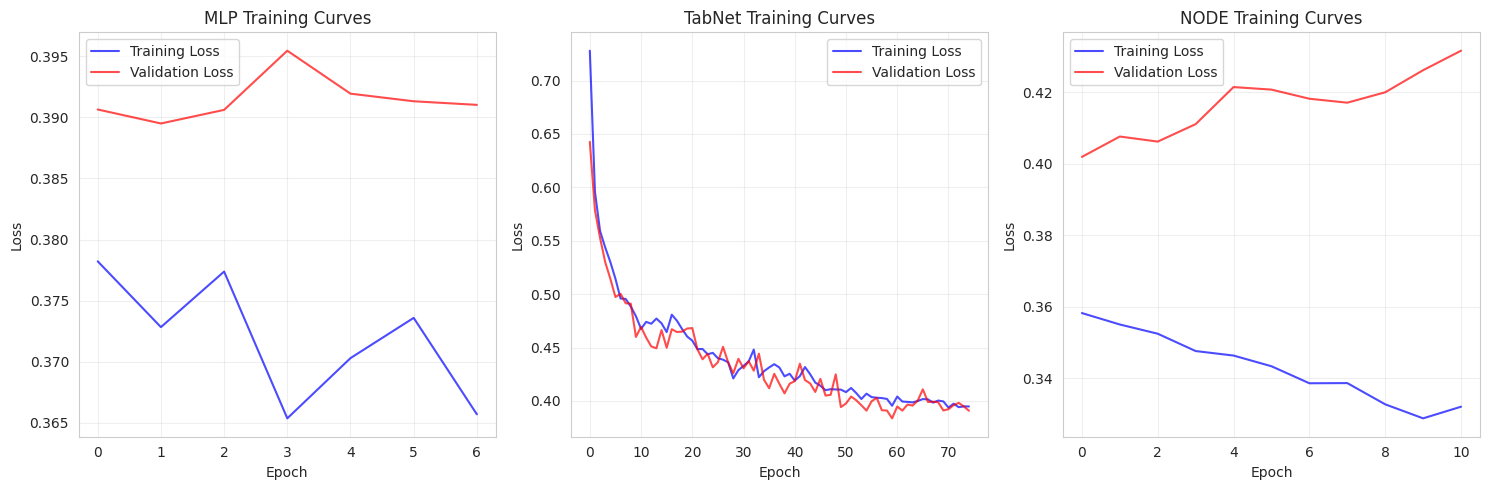

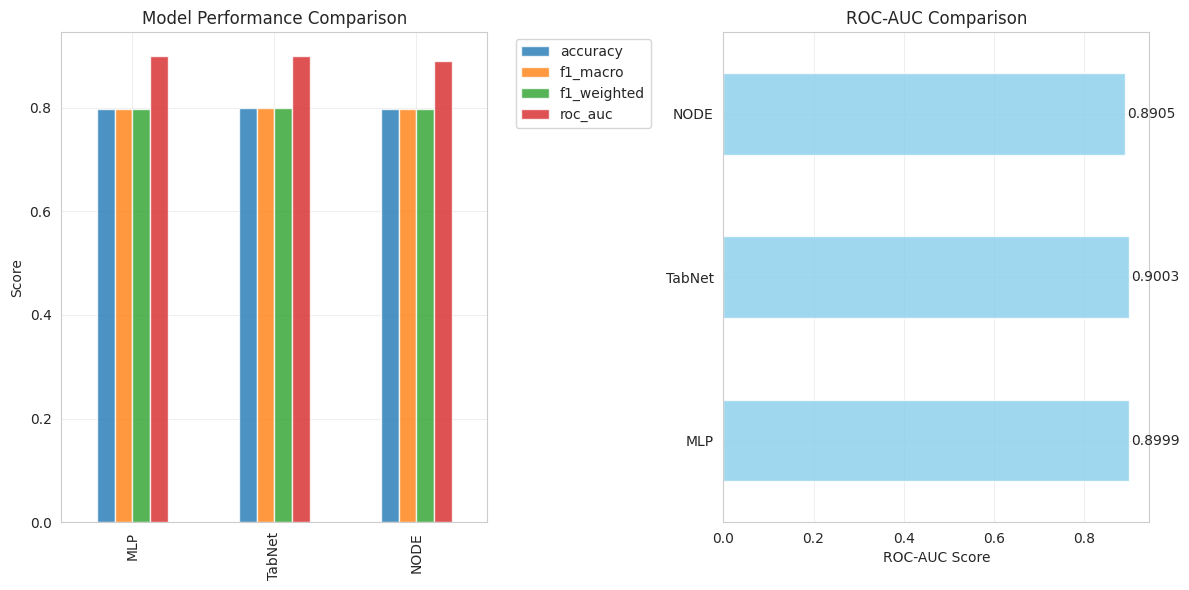


GENERATING PREDICTIONS & SUBMISSIONS
----------------------------------------
2025-09-08 16:10:42,701 - INFO - Generating test predictions...
2025-09-08 16:10:42,704 - INFO - MLP predictions generated
2025-09-08 16:10:43,244 - INFO - TabNet predictions generated
2025-09-08 16:10:43,310 - INFO - NODE predictions generated
2025-09-08 16:10:43,311 - INFO - Ensemble predictions generated
2025-09-08 16:10:43,320 - INFO - Submission saved: submission_tabnet.csv
2025-09-08 16:10:43,338 - INFO - All comparison submissions saved!

MODEL INSIGHTS & RECOMMENDATIONS
--------------------------------------------------
Summary:
  • Best performing model: TabNet
  • Best ROC-AUC score: 0.9003
  • Number of features: 19
  • Training samples: 6,954
  • Validation samples: 1,739
  • Test samples: 4,277

Model Complexity:
  • MLP: 10,881 parameters
  • NODE: 1,776,769 parameters

Top 10 Feature Importances (TabNet):
             feature  importance
           CryoSleep    0.168890
        Has_Spending   

In [24]:
if 'pipeline' in locals() and pipeline.models:

    # =============================================================================
    # MODEL EVALUATION & COMPARISON
    # =============================================================================

    print("\nMODEL EVALUATION & COMPARISON")
    print("=" * 60)

    # Get comprehensive results
    results_df = pipeline.evaluate_models()

    if not results_df.empty:
        print("\nMODEL COMPARISON TABLE")
        print(results_df.round(4))

        # Find best model
        best_model_by_auc = results_df['roc_auc'].idxmax()
        best_auc_score = results_df.loc[best_model_by_auc, 'roc_auc']

        print(f"\nBest Model (ROC-AUC): {best_model_by_auc} ({best_auc_score:.4f})")

        # =============================================================================
        # DETAILED ANALYSIS
        # =============================================================================

        print(f"\nDETAILED PERFORMANCE ANALYSIS")
        print("-" * 40)

        for model_name in results_df.index:
            print(f"\n{model_name}:")
            for metric, value in results_df.loc[model_name].items():
                print(f"  {metric}: {value:.4f}")

        # =============================================================================
        # VISUALIZATIONS
        # =============================================================================

        print(f"\nGENERATING VISUALIZATIONS")
        print("-" * 40)

        # Plot training curves
        ModelVisualizer.plot_training_curves(pipeline.models)

        # Plot model comparison
        ModelVisualizer.plot_model_comparison(results_df)

        # =============================================================================
        # GENERATE PREDICTIONS & SUBMISSIONS
        # =============================================================================

        print(f"\nGENERATING PREDICTIONS & SUBMISSIONS")
        print("-" * 40)

        # Generate predictions
        predictions, probabilities = pipeline.generate_predictions(use_ensemble=True)

        # Save submissions
        pipeline.save_submission(predictions, best_model_by_auc)

        # =============================================================================
        # MODEL INSIGHTS & RECOMMENDATIONS
        # =============================================================================

        print(f"\nMODEL INSIGHTS & RECOMMENDATIONS")
        print("-" * 50)

        print(f"Summary:")
        print(f"  • Best performing model: {best_model_by_auc}")
        print(f"  • Best ROC-AUC score: {best_auc_score:.4f}")
        print(f"  • Number of features: {len(data_config['feature_names'])}")
        print(f"  • Training samples: {len(data_config['X_train']):,}")
        print(f"  • Validation samples: {len(data_config['X_val']):,}")
        print(f"  • Test samples: {len(data_config['X_test']):,}")

        # Model complexity comparison
        print(f"\nModel Complexity:")
        for name, model in pipeline.models.items():
            if model.is_trained and hasattr(model.model, 'parameters'):
                num_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)
                print(f"  • {name}: {num_params:,} parameters")

        # Feature importance (if available)
        if 'TabNet' in pipeline.models and pipeline.models['TabNet'].is_trained:
            tabnet_model = pipeline.models['TabNet']
            if hasattr(tabnet_model.model, 'feature_importances_'):
                feature_importance = pd.DataFrame({
                    'feature': data_config['feature_names'],
                    'importance': tabnet_model.model.feature_importances_
                }).sort_values('importance', ascending=False)

                print(f"\nTop 10 Feature Importances (TabNet):")
                print(feature_importance.head(10).to_string(index=False))

    else:
        print("No trained models found for comparison!")

else:
    print("Pipeline not available. Please run the training cells first.")

### SAVE & LOAD MODELS

In [22]:
def save_all_models(pipeline: ModelTrainingPipeline, save_path: str = "./models"):
    """Save all trained models"""
    if not pipeline.models:
        LOGGER.warning("No models to save!")
        return

    saved_models = []
    for name, model in pipeline.models.items():
        if model.is_trained:
            try:
                model.save_model(save_path)
                saved_models.append(name)
            except Exception as e:
                LOGGER.error(f"Error saving {name}: {e}")

    LOGGER.info(f"Saved models: {saved_models}")
    return saved_models

def load_all_models(model_configs: Dict[str, Any], save_path: str = "./models") -> Dict[str, BaseModel]:
    """Load all saved models"""
    models = {}

    for model_type, config in model_configs.items():
        try:
            if model_type == 'mlp':
                model = MLPModel(config)
                model.build_model(len(data_config['feature_names']))
                model.load_model(save_path)
                models['MLP'] = model

            elif model_type == 'tabnet':
                model = TabNetModel(config)
                model.load_model(save_path)
                models['TabNet'] = model

            elif model_type == 'node':
                model = NODEModel(config)
                model.build_model(len(data_config['feature_names']))
                model.load_model(save_path)
                models['NODE'] = model

            LOGGER.info(f"Loaded {model_type.upper()} model")

        except Exception as e:
            LOGGER.error(f"Error loading {model_type}: {e}")

    return models

# Usage examples:
if 'pipeline' in locals():
    print("Save models now:")
    saved_models = save_all_models(pipeline)

Save models now:
2025-09-08 16:07:38,772 - INFO - Model saved: models/mlp_model.pkl
2025-09-08 16:07:38,948 - INFO - Model saved: models/tabnet_model.pkl
2025-09-08 16:07:39,061 - INFO - Model saved: models/node_model.pkl
2025-09-08 16:07:39,062 - INFO - Saved models: ['MLP', 'TabNet', 'NODE']
